In [1]:
import numpy as np
import seaborn, math, os
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from copy import deepcopy

C:\Anaconda\envs\py34\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
np.set_printoptions(precision=3)

In [3]:
%matplotlib nbagg

## Preliminares

### Comunidades

In [4]:
files = os.listdir("./comunidades")
files.sort()
#print(files)
files = list(filter(lambda x: x[-5] == "m", files))
#print(files)

all_condiciones_iniciales = [np.loadtxt("./comunidades/" + file[:21] + "c.txt") for file in files]
all_tasas_reproduccion = [np.loadtxt("./comunidades/" + file[:21] + "v.txt") for file in files]
all_matriz_interacciones = [np.loadtxt("./comunidades/" + file) for file in files]

Disp = {"b": round((0.7*Manejos["b"] + 2) /9, 1),
        "m": round((0.7*Manejos["m"] + 2) /9, 1),
        "i": round((0.7*Manejos["i"] + 2) /9, 1)}

Manejos_num = {"b": round(-0.1*Manejos["b"] + 1.1, 1),
               "m": round(-0.1*Manejos["m"] + 1.1, 1),
               "i": round(-0.1*Manejos["i"] + 1.1, 1)}

print("Manejos", Manejos, "Manejos_num", Manejos_num, "Disp", Disp)

### Paisaje

In [5]:
Manejos = {"b": 1.,
           "m": 6.,
           "i": 10.}

In [6]:
%run genera_tipo_matriz_agroecologica.py

In [7]:
# Convertir el paisaje a un arreglo numérico para graficar
def paisaje_numerico(paisaje, Manejos):    
    paisaje_numerico = deepcopy(paisaje)
    for i in range(len(paisaje)):
            for j in range(len(paisaje[0])):
                paisaje_numerico[i][j] = Manejos[paisaje[i][j]]
    
    return np.array(paisaje_numerico)

In [8]:
paisaje1 = genera_tipo_matriz_agroecologica(x_celdas = 10, y_celdas = 10, n_bosque=10, 
                                           posicion_bosque="random", 
                                           n_milpa=40, posicion_milpa="random")

In [9]:
paisaje1_num = paisaje_numerico(paisaje1, Manejos)

In [10]:
paisaje2 = genera_tipo_matriz_agroecologica(x_celdas = 10, y_celdas = 10, n_bosque=10, 
                                           posicion_bosque=[(4,3),(4,6),(4,5),(4,4),(4,7),
                                                            (5,3),(5,6),(5,5),(5,4), (5,7)], 
                                           n_milpa=0, posicion_milpa="random")

In [279]:
seaborn.heatmap(paisaje1_num, cmap = "YlGn_r", vmin = 1, square=True, vmax = 10)

## Probando modelo

### Funciones

In [11]:
def migracion_esp(X, tp, L):
    """
    version 0.002
    **LA MIGRACION QUE SE USA AHORA**
    Funcion que asigna cuanta poblacion migra
    dependiendo del parche en el que este
    Los valores de migración están guardados en el 
    diccionario L
    L['b'] = valor bosque
    L['m'] = valor milpa 
    L['i'] = valor intensivo
    X es la matriz de dimensión 3 X(x,y,i) donde 
    la especie i-esima tiene su representación para 
    todos los parches
    t es la distribución de paisajes de parche en todo el 
    espacio
    """
    s = X.shape
    #print tp
    t = np.array(tp)
    #print t
    P = np.zeros(s, dtype=float)
    G = np.zeros(s, dtype=float)
    R = np.zeros(s, dtype=float) 
    #print "Especies "
    for idx in range(s[2]):
        esp = X[:,:,idx]
        dm = esp.shape
        xesp, yesp = dm
        #print "Espacio de la especie ", idx, ": ", xesp,":",yesp
        loss_e = np.zeros( dm, dtype=float ) 
        gain_e = np.zeros ( dm, dtype=float )       
        for x in range(xesp):
            for y in range(yesp):
                #print t[x,y]
                loss_e[x,y] = esp[x,y] * L[t[x,y]]
        for x in range(-1,dm[0]):
            for y in range(-1,dm[1]):
                gain_e[x,y] = (loss_e[(x-1)%dm[0],(y-1)%dm[1]]+loss_e[(x-1)%dm[0],y%dm[1]]+loss_e[(x-1)%dm[0],(y+1)%dm[1]]+loss_e[x%dm[0],(y-1)%dm[1]]+loss_e[x%dm[0],(y+1)%dm[1]]+loss_e[(x+1)%dm[0],(y-1)%dm[1]]+loss_e[(x+1)%dm[0],y%dm[1]]+loss_e[(x+1)%dm[0],(y+1)%dm[1]])/8
        P[:,:,idx] = loss_e
        G[:,:,idx] = gain_e
        R[:,:,idx] = esp +( gain_e - loss_e )
      
    return R 

def lotka1(x, t, r, a, manejo): 
    """
    Ecuacion de lotka volterra generalizada que incorpora la intensidad de manejo.
    **De esta forma, la población crece en forma proporcional al manejo.
    """
    r = r / manejo
    r[r > 0] = r[r > 0] * (manejo) ** 2
    return (x * (r + np.dot(a, x)))

def muerte(x, m):
    """
    Recibe  x = poblacion
            m = tasa muerte cte o np.array
    Regresa x = poblacion superviviente  np.array
    """
    x = x - x*m
    return x

In [12]:
def modificar_matriz(m):
    for i in range(10):
        m[i][i] *= 15
    return m

In [13]:
def modificar_tasas(tasa):
    tasa[tasa > 0] = tasa[tasa > 0] * 20
    return tasa

In [14]:
def modificar_condiciones0(c0):
    c0 = c0 * 10
    return c0

In [15]:
%run genera_poblacion_inicial.py

In [16]:
% run medidas_biodiversidad.py

### Parámetros iniciales

In [17]:
matriz_interacciones = deepcopy(all_matriz_interacciones[187])
tasas_reproduccion = deepcopy(all_tasas_reproduccion[187])
condiciones_iniciales = deepcopy(all_condiciones_iniciales[187])

In [18]:
matriz_interacciones = modificar_matriz(matriz_interacciones)
tasas_reproduccion = modificar_tasas(tasas_reproduccion)
condiciones_iniciales = modificar_condiciones0(condiciones_iniciales)

In [19]:
t_total = 20

In [20]:
paisaje = paisaje1

In [21]:
x_celdas = len(paisaje)
y_celdas = len(paisaje[1])
n_especies = len(matriz_interacciones)

Disp = {"b": round((0.7*Manejos["b"] + 2) /9, 1),
        "m": round((0.7*Manejos["m"] + 2) /9, 1),
        "i": round((0.7*Manejos["i"] + 2) /9, 1)} #tasas dipersión
    

poblacion = np.zeros((t_total + 1, x_celdas, y_celdas, n_especies))

# TO DO: verificar que esto genere la población inicial en el t = 0 --- OK
poblacion[0,:,:,:] = genera_poblacion_inicial(paisaje, n_especies,
                                              p0_bosque = condiciones_iniciales, 
                                              p0_milpa=0, p0_intensivo=0)

C:\Users\hp\Desktop\proyectof\genera_poblacion_inicial.py:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if p0_bosque=="random": poblacion_0[x][y] = [1/random.random() for i in range(n_especies)]


In [22]:
for t in range(1, t_total+1):
    poblacion[t, :, :, :] = deepcopy(poblacion[t-1]) # la poblacíón en el tiempo anterior 
        
    for iter in range(6):
        # Migración
        poblacion[t, :, :, :] = migracion_esp(poblacion[t, :, :, :], paisaje, Disp)

        # Muerte
        for i in range(x_celdas): #para todo x y
            for j in range(y_celdas):
                tasa_muerte = (0.9/9) * (Manejos[paisaje[i][j]] - 1)
                poblacion[t, i, j, :] = muerte(poblacion[t, i, j, :], tasa_muerte)

    # Lotka - dinámica de poblaciones
    for i in range(x_celdas): #para todo x y
        for j in range(y_celdas):
            if paisaje[i][j] != "i":
                # En todos los parches ocurren interacciones ecológicas
                manejo_numerico = -0.1 * Manejos[paisaje[i][j]] + 1.1
                poblacion[t, i, j, :]= odeint(lotka1, poblacion[t, i, j, :], [0, 0.5],
                                        args=(tasas_reproduccion, matriz_interacciones,
                                              manejo_numerico))[-1]


In [24]:
poblacion.shape

(41, 10, 10, 10)

In [23]:
biomasa_celda_0 = medidas_por_celda(poblacion, 20)[0]
riqueza_celda_0 = medidas_por_celda(poblacion, 20)[1]

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
seaborn.heatmap(biomasa_celda_0, yticklabels=False,
               xticklabels=False, vmin = 0.0, annot=True, fmt=".1f", square=True)
plt.show() 

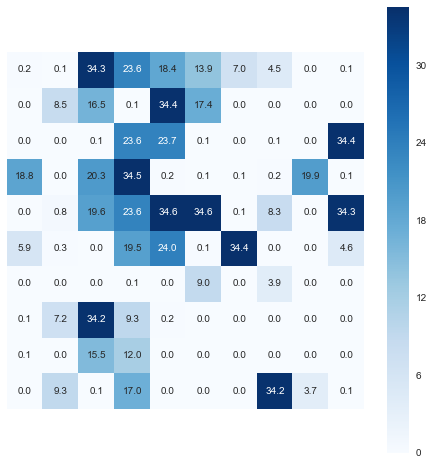

In [26]:
#Una especie
%matplotlib inline
fig = plt.figure(figsize=(8,8))
seaborn.heatmap(poblacion[20, :, :, 5], yticklabels=False,
               xticklabels=False, vmin = 0.0, annot=True, fmt=".1f", square=True, cmap="Blues")
plt.show() 

In [141]:
print(riqueza_paisaje(poblacion, 0)[1])
print(riqueza_paisaje(poblacion, 2)[1])
print(riqueza_paisaje(poblacion, 22)[1])
print(riqueza_paisaje(poblacion, 40)[1])

10
8
8
8


In [30]:
print(riqueza_paisaje_m(poblacion, paisaje, 0)[1])
print(riqueza_paisaje_m(poblacion, paisaje, 3)[1])
print(riqueza_paisaje_m(poblacion, paisaje, 5)[1])
print(riqueza_paisaje_m(poblacion, paisaje, 20)[1])

0
8
8
8


In [29]:
def riqueza_paisaje_m(poblacion, paisaje, t=-1):
    """ Entrada: un arreglo poblacion = [tiempo] [x][y] [especieA][especieB][...]
        Salida: la biomasa y la riqueza de especies en UN tiempo, en las celdas que no son bosque;
        si no se especifica el tiempo se toma la última iteración.
        Adaptada del programa original.
    """
    riqueza = np.zeros(poblacion.shape[3])
    for idx in range(poblacion.shape[3]):
        
        for i in range(x_celdas): #para todo x y
            for j in range(y_celdas):
                if paisaje[i][j] != "b":
                    riqueza[idx] += poblacion[t,i,j,idx]  
    
    biomasa = np.sum(riqueza) #suma total de individuos al final de n iteraciones - biomasa
    return biomasa, len(riqueza[riqueza > 5])  #riqueza de especies al final de n iteraciones

In [ ]:
print(condiciones_iniciales)

In [ ]:
riqueza = np.zeros(poblacion.shape[3])
#riqueza[1] =1
len(riqueza[riqueza > 0.1])

In [ ]:
poblacion[40, :, :, 1]

In [ ]:
riqueza_paisaje_1 = riqueza_paisaje(poblacion1)[1]
print riqueza_paisaje_1
riqueza_celda_1 = medidas_por_celda(poblacion1)[1]
print riqueza_celda_1
seaborn.heatmap(riqueza_celda_1, vmin = 0, vmax = 10) # vmax = n_especies

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
# Original de numericalmooc, por Lorena Barba
from IPython.core.display import HTML
css_file = "C:/Users/hp\Desktop/proyectof/style2.css"
HTML(open(css_file, "r").read())